In [1]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf

     |████████████████████████████████| 6.4 MB 41.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Monte Carlo (MC) simulation for stock price prediction
We can use MC simulations to draw random variables assuming an underlying distribution. Then, we can approximate quantities of intereset by sample statistics. 

## Stock price model
In this example, we assume a simple model where the stock price ($S_t$) only depends on its previous value ($S_{t-1}$) times the stock (continous compund) return ($r$), i.e.

\begin{equation}
S_t = S_{t-1} * \exp^r \tag{1}
\end{equation}

We will get back to the definition for the return $r$, but now let's get some stock prices from Yahoo and make some plots 🧔

[*********************100%***********************]  1 of 1 completed


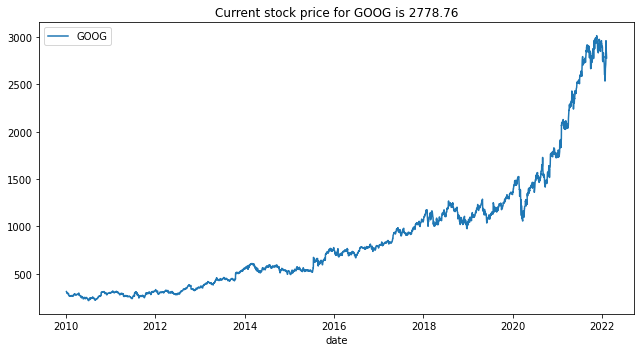

In [ ]:
# define a stock ticker, e.g. Google
ticker = 'GOOG'
# stock ticker symbols: https://stockanalysis.com/stocks/

# define time interval and get the closing prices
data = yf.download(ticker, start="2010-01-01")['Adj Close']
# you can also specify an end date 
#data = yf.download(ticker, start="2010-01-01", end="2021-12-31")['Adj Close']

# Visualize the data
fig = plt.figure(figsize=(9,5))
plt.plot(data, label=ticker)
plt.title('Current stock price for {0} is {1:.2f}'.format(ticker,data[-1]))
plt.xlabel('date')
plt.legend()
plt.tight_layout()
plt.show()


Now let's calculate log-returns using the `pct_change`function in `pandas`

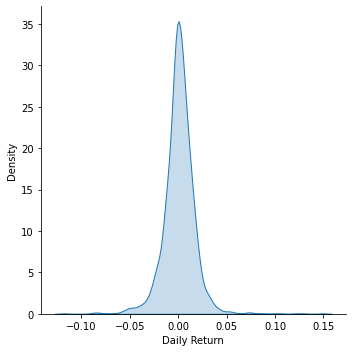

In [ ]:
# define log returns as 1 + r, 
# where at time t is r_t = (S_t - S_t-1)/ S_t-1
log_returns = np.log(1 + data.pct_change().dropna())
# Plot
sns.displot(log_returns,kind='kde',fill=True)
plt.xlabel("Daily Return")
plt.show()

## Stock returns
We will assume that stock returns $r$ are given by a *drift* times the stock *volatility*, i.e.
\begin{equation}
r = drift * volatility
\end{equation}
where 
\begin{equation}
drift = \mu - \frac{\sigma^2}{2},
\end{equation}
\begin{equation}
volatility = \sigma*F^{-1}(\epsilon)
\end{equation}
and $F^{-1}$ is the inverse cumulative distribution function and $\epsilon \sim N(0,1)$.


You can think of the drift parameter as a trend or growth rate over time, while the volatility can be seen as a measure of uncertainity.  We estimate $\mu$ and $\sigma^2$ using the sample average and variance of the log returns for the stock price!

In [ ]:
# get mu and var
mu = np.mean(log_returns.values)
var = np.var(log_returns.values)

# calculate the drift 
drift = mu - (0.5*var)

Now we need to define the number of days ahead that our MC simulation will iterate over equation (1) and how many times we actually simulate it. I choose 50 days ahead and 10 000 simulations.

In [ ]:
# define MC parameters
days = 50
sim = 10000

# draw eps ~ N(0,1)
eps = np.random.rand(days, sim)
# calculate the inverse cdf for eps values
z = norm.ppf(eps)
# calulate the volatility
volatility = np.std(log_returns.values)*z

# Now we can calculate (daily) returns
daily_returns = np.exp(drift + volatility)

## Simulation stock prices
We have now all ingredients to apply equation (1) recursively. Let's do that with the following loop 

In [ ]:
# define a matrix to save the MC simulation results
price_paths = np.zeros_like(daily_returns)

# we start using the last stock price
price_paths[0] = data.iloc[-1]

# equation 1 recursively
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_returns[t]

Let's visualize the results! I choose only 20 simulations to visualize the stock price 50 days ahead. Remember we have 10 000 simulations and plotting all will look messy!

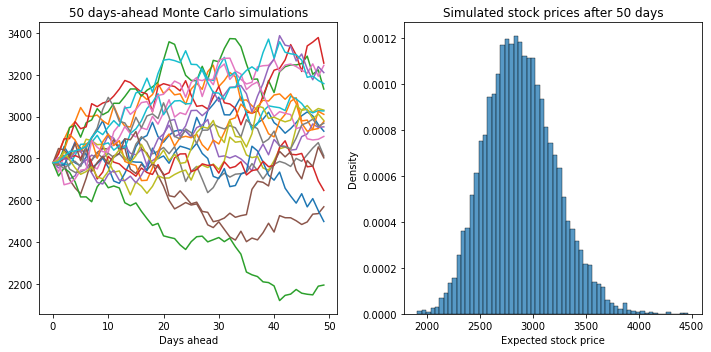

In [ ]:
idx = np.random.choice(sim,20)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('50 days-ahead Monte Carlo simulations')
ax[0].set(xlabel='Days ahead')
ax[0].plot(price_paths[:,idx])

sns.histplot(price_paths[-1,:], stat='density', ax=ax[1])
ax[1].set_title('Simulated stock prices after 50 days')
ax[1].set(xlabel='Expected stock price')
plt.tight_layout()
plt.show()